# <font color='red'>COMPUTER VISION WITH DEEP LEARNING</font>

# <font color='blue'>Face Recognition using GhostFaceNet</font>

### <font color='green'>1. Set up required libraries</font>

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 16.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import faiss
import numpy as np

In [ ]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.3 MB/s eta 0:00:00
  At

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc

In [ ]:
!pip install keras-cv-attention-models
from keras_cv_attention_models import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00


### <font color='green'>2. Face Recognition Model Evaluation and ROC Plotting</font>

In [5]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir, root_img_path):
        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb)
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, names = aa["embs"], aa["imm_classes"], aa["filenames"]
            embs, img_classes = embs.astype("float32"), imm_classes.astype("int")
        else:
            img_shape = (112, 112)
            data = r"/content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/data.csv"
            imgs = pd.read_csv(data)['image'].tolist()
            labels = pd.read_csv(data)['label'].tolist()
            embs = []
            img_classes = []
            names = []
            for i, img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path, img_path)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0)
                emb = self.model_interf(img)
                emb = normalize(np.array(emb).astype("float32"))[0]
                img_class = int(labels[i])
                img_classes.append(img_class)
                embs.append(emb)
                filename = os.path.basename(img_path)
                names.append(filename)
            np.savez(output_dir, embs=embs, imm_classes=img_classes, filenames=names)
            print("file chứa 4720 vector được save tại")
        return np.array(embs), np.array(img_classes), np.array(names)

    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes)
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1])
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            pos_pick_cond = self.imm_classes == register_id
            pos_embs = self.embs[pos_pick_cond]
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist)
            register_base_embs = np.vstack([register_base_embs, register_base_emb])

        new_path = self.output_dir.replace(os.path.basename(self.output_dir), "processed_1000embedding.npz")
        print("saving vector đại diện tại: ", new_path)
        np.savez(new_path, embs=register_base_embs)
        register_base_dists = np.array(register_base_dists).T
        print(register_base_dists.shape)

        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ", register_ids.shape)
        print("self.imm_classes shape: ", self.imm_classes.shape)

        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape)

        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape)

        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists])
        return accuracy, score, label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")
        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig


### <font color=green>3. Evaluate the Model</font>

In [6]:
GhostFaceNetModelPath = r"/content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/GhostFaceNet_W1.3_S1_ArcFace.h5"
ImageTrainingPath = r"/content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/images"

In [8]:
demo_image = Eval_image(GhostFaceNetModelPath, "./VN-celeb", output_dir="/content/data/root_embs/training.npz", root_img_path=ImageTrainingPath)

begin serving


100%|██████████| 864/864 [06:44<00:00,  2.14it/s]

file chứa 4720 vector được save tại


>>>> [base info] embs: (864, 512) imm_classes: (864,) register_ids: (199,)


Evaluating: 100%|██████████| 199/199 [00:00<00:00, 427.64it/s]


saving vector đại diện tại:  /content/data/root_embs/processed_1000embedding.npz
(864, 199)
register_ids shape:  (199,)
self.imm_classes shape:  (864,)
(864, 199)
(864,)
(171072,)
|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |     0.01 |      0.1 |
|:----|---------:|---------:|---------:|---------:|---------:|---------:|
| TPR | 0.967593 | 0.974537 | 0.989583 | 0.996528 | 0.997685 | 0.998843 |


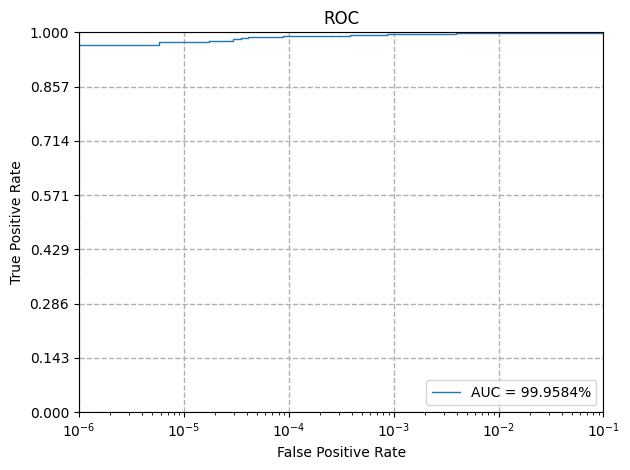

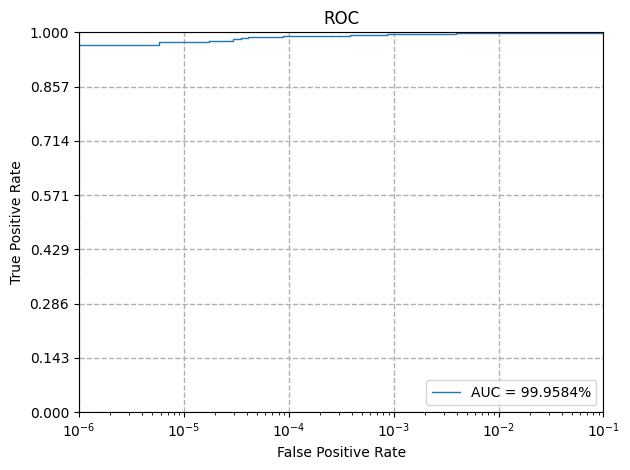

In [9]:
acc,scores,labels = demo_image.do_evaluation()
plot_tpr_far(scores, labels)

### <font color=green>4. Calculate Mean Embeddings for Each Class</font>

In [10]:
register_ids = np.unique(demo_image.imm_classes)
print(">>>> [base info] embs:", demo_image.embs.shape,
      "imm_classes:", demo_image.imm_classes.shape,
      "register_ids:", register_ids.shape)

mean_embss = []
for register_id in tqdm(register_ids, "Evaluating"):
    pos_pick_cond = demo_image.imm_classes == register_id
    pos_embs = demo_image.embs[pos_pick_cond]
    register_base_emb = normalize([np.mean(pos_embs, axis=0)])[0]
    mean_embss.append(register_base_emb)
mean_embss = np.array(mean_embss)

>>>> [base info] embs: (864, 512) imm_classes: (864,) register_ids: (199,)


Evaluating: 100%|██████████| 199/199 [00:00<00:00, 3226.69it/s]


### <font color=green>5. Detect and Align Faces</font>

In [18]:
portraits_root_path = r"/content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/portraits"

In [19]:
from face_detector import YoloV5FaceDetector
folder_raw_face = portraits_root_path
data_path = YoloV5FaceDetector().detect_in_folder(folder_raw_face)

Detecting: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

>>>> Saved aligned face images in: /content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/portraits_aligned_112_112


### <font color=green>6. Process and Extract Embeddings for New Images</font>

In [22]:
portraits_root_path = r"/content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/portraits_aligned_112_112/"

In [26]:
imgs = [portraits_root_path + "portrait_1.jpeg", portraits_root_path + "portrait_2.jpeg"]
personal_embeddings = np.array([]).reshape(0, 512)
for img_path in imgs:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
    else:
        print(f"Image loaded successfully: {img_path}")
    img = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    semb = demo_image.model_interf(img)
    semb = normalize(np.array(semb).astype("float32"))[0]
    personal_embeddings = np.vstack([personal_embeddings, semb])

p_register_base_emb = normalize([np.mean(personal_embeddings, axis=0)])[0]
normalized_embeddings_new = np.vstack([mean_embss.copy(), p_register_base_emb])
print(normalized_embeddings_new.shape)

Image loaded successfully: /content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/portraits_aligned_112_112/portrait_1.jpeg
Image loaded successfully: /content/drive/MyDrive/Colab Notebooks/Q4_Face_Recognition/portraits_aligned_112_112/portrait_2.jpeg
(200, 512)


### <font color=green> 7. Create FAISS Index for Efficient Search </font>

In [27]:
aa = np.load("/content/data/root_embs/training.npz")
embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
emb, img_class = embs.astype("float32"), imm_classes.astype("int")
print(emb.shape)
dimensions = 512

metric = 'cosine'

if metric == 'euclidean':
    index = faiss.IndexFlatL2(dimensions)
elif metric == 'cosine':
    index = faiss.IndexFlatIP(dimensions)

(864, 512)


In [35]:
imm_classes_new = np.append(imm_classes, 199)
imm_classes_new = np.append(imm_classes_new, 199)
filename_new = np.append(filename, imgs[0])
filename_new = np.append(filename_new, imgs[1])

In [36]:
imm_classes

array([  0,   0,   1,   1,   1,   1,   1,   2,   2,   3,   3,   4,   4,
         4,   4,   4,   5,   5,   6,   6,   7,   7,   7,   7,   8,   8,
         8,   8,   9,   9,   9,   9,   9,   9,   9,   9,  10,  10,  11,
        11,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  13,
        13,  14,  14,  14,  14,  14,  14,  15,  15,  16,  16,  16,  16,
        17,  17,  17,  18,  18,  18,  18,  19,  19,  20,  20,  21,  21,
        21,  22,  22,  22,  22,  23,  23,  24,  24,  24,  24,  24,  24,
        24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
        24,  24,  24,  24,  24,  24,  24,  24,  24,  25,  25,  25,  26,
        26,  26,  27,  27,  28,  28,  28,  29,  29,  30,  30,  31,  31,
        32,  32,  33,  33,  33,  34,  34,  34,  34,  34,  34,  34,  34,
        34,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  37,  37,
        38,  38,  38,  38,  39,  39,  40,  40,  41,  41,  42,  42,  43,
        43,  44,  44,  45,  45,  45,  45,  46,  46,  46,  46,  4

### <font color=green>8. Query the Index for Image Similarity</font>

In [37]:
img = cv2.imread(portraits_root_path + "portrait_3.jpeg")
img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
# single embeeding
semb = demo_image.model_interf(img)
semb = normalize(np.array(semb).astype("float32"))[0] # (512)

In [38]:
index.add(normalized_embeddings_new.astype(np.float32))

In [39]:
k = 1
target_representation = np.array(semb, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0)
distances, neighbors = index.search(target_representation, k)

In [40]:
distances[0]

array([0.80291826], dtype=float32)

ảnh query mà user dùng để checkin:


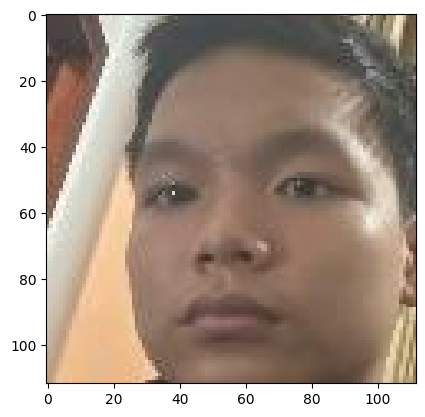

Hệ thống nhận thấy Ảnh query khớp với người có identity =  [199]
Dưới đây là các ảnh trong train dataset của người có identity =  [199]


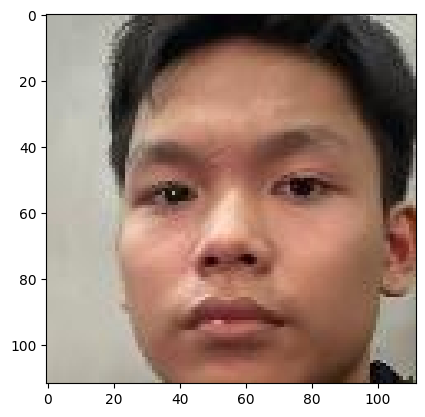

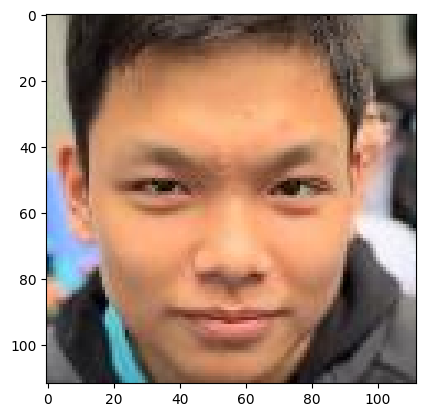

In [41]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0])
from matplotlib import pyplot as plt
print("ảnh query mà user dùng để checkin:")
plt.imshow(np.reshape(img,(112,112,3)))
plt.show()
print("Hệ thống nhận thấy Ảnh query khớp với người có identity = ",neighbors.tolist()[0])
print("Dưới đây là các ảnh trong train dataset của người có identity = ",neighbors.tolist()[0])
for i in id_list:
    im  = plt.imread(filename_new[i][0])
    plt.imshow(im)
    plt.show()